## [2021-1] 웹과 텍스트마이닝 개론 기말 프로젝트

### 주제: 쇼핑 리뷰 크롤링 데이터를 바탕으로 특정 상품 최신 리뷰의 감성 경향 분석

#### 휴먼기계바이오공학부 1870021 김수아

#### * 프로젝트 설명: 
1. 데이터의 종류: 네이버 쇼핑 사이트에서 제공하는 리뷰를 스크래핑한 데이터
    (긍정리뷰 1200개 + 부정리뷰 1140개 = 총 2460개 데이터 크롤링)
2. 웹 스크래핑 포함 여부 : 포함
3. 텍스트마이닝 관련 코드 포함 여부 : 데이터 전처리 코드 및 LSTM 기반 감성분류 코드 포함

### 1. 데이터 수집

- [네이버 쇼핑](http://www.bosa.co.kr/)의 화장품/미용>스킨케어의 가장 많은 리뷰를 가진 상품의 리뷰 내용을 중심으로 스크래핑하였다.
- 리뷰내용과 별점은 selenium의 webdriver 모듈을 활용하여 수집하였다.
- 이 때, 4점에서 5점은 긍정적인 리뷰, 1점에서 3점은 부정적인 리뷰로 분류하였다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 리뷰 본문 스크래핑을 위한 라이브러리
from selenium import webdriver

# selenium stale 에러 해결 위한 모듈
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 리뷰 수가 가장 많은 상품(피지오겔 로션)의 평점 리뷰 데이터 확보
url = 'https://search.shopping.naver.com/catalog/9273983533?NaPm=ct%3Dkpuvecfs%7Cci%3D9a5c1f46854ea7803cc4ed99991437bd0e517721%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D8bb3b48c8f518ad9bfeaf1eb724a0ed95b252336'

- 긍정 리뷰 데이터 수집
    - positive 데이터 프레임에 저장

In [3]:
# 긍정 리뷰: 4점~5점

driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)

positive_content_list=[]

for positive in [2, 3]:
    # 해당 url에 해당하는 페이지를 가져옴
    driver.get(url)
    
    # 평점 선택(4점~5점)
    driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[%s]/a' %positive).click()
    time.sleep(2)
    driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[11]').click()
    time.sleep(2)
        
    for maxPage in range(3):
        for page in range(2,12):
            for child in range(1, 21): 
                content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
                time.sleep(2)
                positive_content_list.append(content.text)
            driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
            time.sleep(2)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[12]').click()
        time.sleep(2)

In [4]:
# 데이터 확인

print("긍정 리뷰 개수: ", end ='')
print(len(positive_content_list))

긍정 리뷰 개수: 1200


In [5]:
# 긍정 리뷰 라벨링: 1
positive_label_list = [1 for i in range(len(positive_content_list))]

# 긍정 리뷰에 대한 데이터프레임 생성
positive = pd.DataFrame({'content': positive_content_list,
                   'label': positive_label_list})

positive

,content,label
0,잘쓸께요~ 일단 배송빨랐구요~가격도 다른곳에비해 싸게잘샀어요~샘플이 많아서 좋네요~...,1
1,늘 쓰던겁니다.저한테는 요상품이 제일 잘맞고 가장 촉촉함이 오래갑니다.겨울엔 요것만...,1
2,피지오겔 페이셜처음 써봐요..농도가 묽지도 되직하지도 않게 여름에 쓰기 딱좋아요.....,1
3,"악곤성에 민감성이라서 크림, 로션은 피지오겔만 쓰는데, 바디로션은 첨 시켜봤어요. ...",1
4,피지오겔 좋다는건 익히 들어 알았지만 막상 내가 써보니 보습력이 짱이네요^^ 더운 ...,1
...,...,...
1195,잘받았습니다~~\n샘플로 주는거 쓰고있는데 잘 맞아요.\n본품도 잘맞길..,1
1196,추가구성 안와서 보내달라고 했는데 잘 처리해주셔서 감사합니다,1
1197,피부다극없고 향도 자극적이지않고 촉촉하니 좋아요,1
1198,확실히 피지오겔 바르고나면 촉촉해요,1


- 부정 리뷰 데이터 수집
    - negative 데이터 프레임에 저장

In [9]:
# 부정 리뷰 저장하는 리스트
negative_content_list=[]

# 2점

driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)

# 해당 url에 해당하는 페이지를 가져옴
driver.get(url)
    
# 평점 선택(2점)
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[5]/a').click()
time.sleep(2)
        
for page in range(1,9):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [10]:
# 1점

driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)

# 해당 url에 해당하는 페이지를 가져옴
driver.get(url)
    
# 평점 선택(1점)
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[6]/a').click()
time.sleep(2)
        
for page in range(1,6):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [11]:
# 데이터 확인
print("부정 리뷰 개수: ", end ='')
print(len(negative_content_list))

부정 리뷰 개수: 260


- 긍정 리뷰 데이터와 수를 맞추기 위해 부정 리뷰에 대한 웹 스크롤링 추가 진행

In [12]:
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)


driver.get('https://search.shopping.naver.com/catalog/14275632421?NaPm=ct%3Dkpvc8iyw%7Cci%3Df559404be3b8b84bea9e11b8ee1606ec6386de41%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3Dc43561f1fe5c35852a7e25164fe7134ab78cc01c')
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[5]/a').click()
time.sleep(2)
        
for page in range(1,10):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [13]:
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)


driver.get('https://search.shopping.naver.com/catalog/4048397218?NaPm=ct%3Dkpvcmz14%7Cci%3D79d7ce4b128df52f8e0666ad9439929a733170f8%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D7c37ca30f853d3e7bdab06325eb0bf4bc3afc7ae')
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[5]/a').click()
time.sleep(2)
        
for page in range(1,11):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [14]:
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)


driver.get('https://search.shopping.naver.com/catalog/4048397218?NaPm=ct%3Dkpvcmz14%7Cci%3D79d7ce4b128df52f8e0666ad9439929a733170f8%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D7c37ca30f853d3e7bdab06325eb0bf4bc3afc7ae')
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[5]/a').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[11]').click()
time.sleep(2)
        
for page in range(2,12):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [16]:
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)


driver.get('https://search.shopping.naver.com/catalog/4048397218?NaPm=ct%3Dkpvcmz14%7Cci%3D79d7ce4b128df52f8e0666ad9439929a733170f8%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D7c37ca30f853d3e7bdab06325eb0bf4bc3afc7ae')
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[6]/a').click()
time.sleep(2)
        
for page in range(1,6):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [18]:
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(3)


driver.get('https://search.shopping.naver.com/catalog/13304339329?NaPm=ct%3Dkpvckhiw%7Cci%3D5f36bf8ff02578236a343db2e841da86c6f91b43%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D6a34e240effcf43fce66eeee2d38db1e2f43efb2')
driver.find_element_by_xpath('//*[@id="section_review"]/div[2]/div[2]/ul/li[5]/a').click()
time.sleep(2)
        
for page in range(1,11):
    for child in range(1, 21): 
        content = driver.find_element_by_css_selector('#section_review > ul > li:nth-child(%s) > div.reviewItems_review__1eF8A > div.reviewItems_review_text__2Bwpa > p' %child)
        time.sleep(2)
        negative_content_list.append(content.text)
        driver.find_element_by_xpath('//*[@id="section_review"]/div[3]/a[%s]' %page).click()
        time.sleep(2)

In [19]:
print(len(negative_content_list))

1140


In [20]:
# 부정 리뷰 라벨링: 0
negative_label_list = [0 for i in range(len(negative_content_list))]

# 부정 리뷰에 대한 데이터프레임 생성
negative = pd.DataFrame({'content': negative_content_list,
                   'label': negative_label_list})

negative

,content,label
0,감사합니다. 항 상 주문하는 상품 입니다. 다들 아시는 상품이니 뭐 이젠 왠지 집안...,0
1,아기가 태어날때부터 항상쓰던 피지오겔이라 사은품도주고 가격도괜찮아서 구매했어요. 근...,0
2,용기의 원터치캡이 넘 헐렁해요 여행 갈때도 들고 다니기 좋고 떨어뜨려도 깨질 염려도...,0
3,제품뒷면 피지오겔글씨아래에 용량이위치해있어서맞는지문의드렸는데 네 라고답변이~~화장품...,0
4,저에겐 명성만큼 놀랍진 않았네요 어느날부터 갑자기 피부가 극예민해져서 기초제품부터 ...,0
...,...,...
1135,8/20에 주문했는데 이제받음,0
1136,배송이 정말 2달걸린듯,0
1137,배송이 오래걸림,0
1138,배송 엄청 느렸어요 추석이끼었다지만 8월말에시킨게 10월 초에오다니 ㄷㄷㄷ,0


In [21]:
# 훈련용/테스트용 데이터셋 완성: 긍정/부정 데이터프레임 결합
# train과 test 데이터 셋은 9:1의 비율로 지정

train_data = pd.concat([positive[:1080], negative[:1026]])
test_data = pd.concat([positive[1080:], negative[1026:]])

In [22]:
# 데이터 섞기
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [23]:
# 최종 데이터 확인

print('train 리뷰 개수 :',len(train_data))
print('test 리뷰 개수 :',len(test_data))

train 리뷰 개수 : 2106
test 리뷰 개수 : 234


In [24]:
# 훈련용 데이터 상위 5개 데이터 확인
train_data[:5]

,content,label
0,키엘 처음 써보는건데 아직 사용은 안해봐서 잘 모르겠구요 유명한 만큼 좋긴 하겠죠 ...,0
1,항상 사용중인 피지오겔 로션 저렴하게 구입했습니다. 배송도 매우 빠릅니다. 잘 받았...,1
2,맘에 듭니다 배송도 빠르고 as도 잘 처리해주셨습니다,1
3,아토피 피부에 자극없이 좋아요,1
4,예전에 쓰다가 이번에 다시 쓰는데 좋네요,1


In [25]:
# 테스트용 데이터 상위 5개 데이터 확인
test_data[:5]

,content,label
0,쓰던거라 만족하면 사용중이에요,1
1,원래쓰던 제품인데 여름엔 너무 안맞네여ㅜㅜ,1
2,배송도 빠르고 피부에도 잘맞아서 주문했어요,1
3,피부에 잘맞는지 알아보고 구매하는게.. 유분이 정말 많거나 문제성 피부에만 맞는 앰...,0
4,"잘 받았습니다. 근데 리뉴얼 버전은 그닥 효과가 없는 것 같네요,",0


- 데이터 분포 확인

<AxesSubplot:>

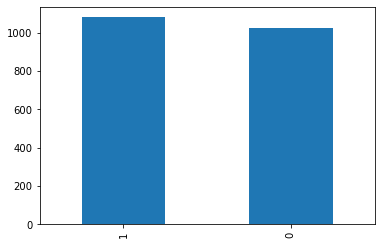

In [26]:
# train 데이터
train_data['label'].value_counts().plot(kind = 'bar')

In [27]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   1026
1      1   1080


- 백업용 데이터 저장

In [29]:
train_data.to_csv('C:/Users/sua91/2021-1 웹과텍스트마이닝개론/train.csv')

In [30]:
test_data.to_csv('C:/Users/sua91/2021-1 웹과텍스트마이닝개론/test.csv')